[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [5]:
!pip install langchain-groq langchain-core langgraph langgraph-prebuilt ipython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 23.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ["GROQ_API_KEY"] = ""


Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [ ]:
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [ ]:
# ================================
# 🤖 LangGraph ReAct Agent (Groq)
# ================================

# --- Imports ---
import os, math
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# --- Ensure API Key is Set ---
os.environ["GROQ_API_KEY"] = ""

# ================================
# 🧮 Define Tools
# ================================
def add(a: float, b: float) -> float:
    """Adds two numbers."""
    return round(a + b, 2)

def multiply(a: float, b: float) -> float:
    """Multiplies two numbers."""
    return round(a * b, 2)

def divide(a: float, b: float) -> float:
    """Divides two numbers."""
    if b == 0:
        return float('inf') # Handle division by zero
    return round(a / b, 2)

# List of all tools




Let's create our LLM and prompt it with the overall desired agent behavior.

In [13]:
tools = [add, multiply, divide]

# ================================
# 🧠 Define the LLM (Groq)
# ================================
# Groq model names: "llama3-8b-8192", "llama3-70b-8192", "mixtral-8x7b-32768"
llm = ChatGroq(model="openai/gpt-oss-120b")

# Disable parallel tool calls (math needs sequential reasoning)
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# ================================
# 🧩 Define Assistant Node
# ================================
sys_msg = SystemMessage(content="You are a helpful assistant that performs arithmetic step-by-step using tools when needed.")

def assistant(state: MessagesState):
    """Assistant node: decides whether to call a tool or respond directly."""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

In [14]:

# ================================
# 🕸️ Build LangGraph
# ================================
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges (control flow)
builder.add_edge(START, "assistant")

# Conditional routing based on whether a tool call is made
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Routes to tools if tool call detected
)

# Loop: tool outputs go back to assistant
builder.add_edge("tools", "assistant")

# Compile the graph
react_graph = builder.compile()


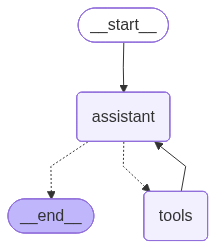

================================ Human Message =================================

Add 3 and 4. Multiply the result by 2. Divide the result by 5.
================================== Ai Message ==================================
Tool Calls:
  add (fc_75982705-88f0-4943-95b7-b7f6cff61ae3)
 Call ID: fc_75982705-88f0-4943-95b7-b7f6cff61ae3
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7.0
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_9e03f2af-74f9-4cdd-945c-d0241d8fc8b4)
 Call ID: fc_9e03f2af-74f9-4cdd-945c-d0241d8fc8b4
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14.0
================================== Ai Message ==================================
Tool Calls:
  divide (fc_a951c7fa-a3cc-47a4-bed2-fc29b539729e)
 Call ID: fc_a951c7fa-a3cc-47a4-bed2-fc29b539729e
  Args:
    a: 14
    b:

In [15]:
# ================================
# 🧭 Visualize the Graph
# ================================
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

# ================================
# 🧑‍💬 Example Conversation
# ================================
messages = [
    HumanMessage(content="Add 3 and 4. Multiply the result by 2. Divide the result by 5."),
]

result = react_graph.invoke({"messages": messages})

# Display each step of reasoning
for msg in result["messages"]:
    msg.pretty_print()

In [16]:
# ================================
# EXTRA EXAMPLE: Split-the-bill
# ================================
print("\n=== Extra Example: Split-the-bill ===")
messages = [
    HumanMessage(
        content=(
            "I bought items costing 12.50, 9.99, and 4.75. "
            "Apply 8% sales tax to the total, then split the final bill evenly among 3 people. "
            "Show each calculation step.")

    )
]

result = react_graph.invoke({"messages": messages})

# Display each step of the ReAct reasoning (assistant/tool/assistant...)
for msg in result["messages"]:
    msg.pretty_print()



=== Extra Example: Split-the-bill ===
================================ Human Message =================================

I bought items costing 12.50, 9.99, and 4.75. Apply 8% sales tax to the total, then split the final bill evenly among 3 people. Show each calculation step.
================================== Ai Message ==================================
Tool Calls:
  add (fc_d12561b0-589c-4233-8ff6-3d248c1852bc)
 Call ID: fc_d12561b0-589c-4233-8ff6-3d248c1852bc
  Args:
    a: 12.5
    b: 9.99
================================= Tool Message =================================
Name: add

22.49
================================== Ai Message ==================================
Tool Calls:
  add (fc_a0459d10-40a6-4ac8-aea6-f4e8b839f2a2)
 Call ID: fc_a0459d10-40a6-4ac8-aea6-f4e8b839f2a2
  Args:
    a: 22.49
    b: 4.75
================================= Tool Message =================================
Name: add

27.24
================================== Ai Message ==================================

## LangSmith trace of my example

We can look at traces in LangSmith.

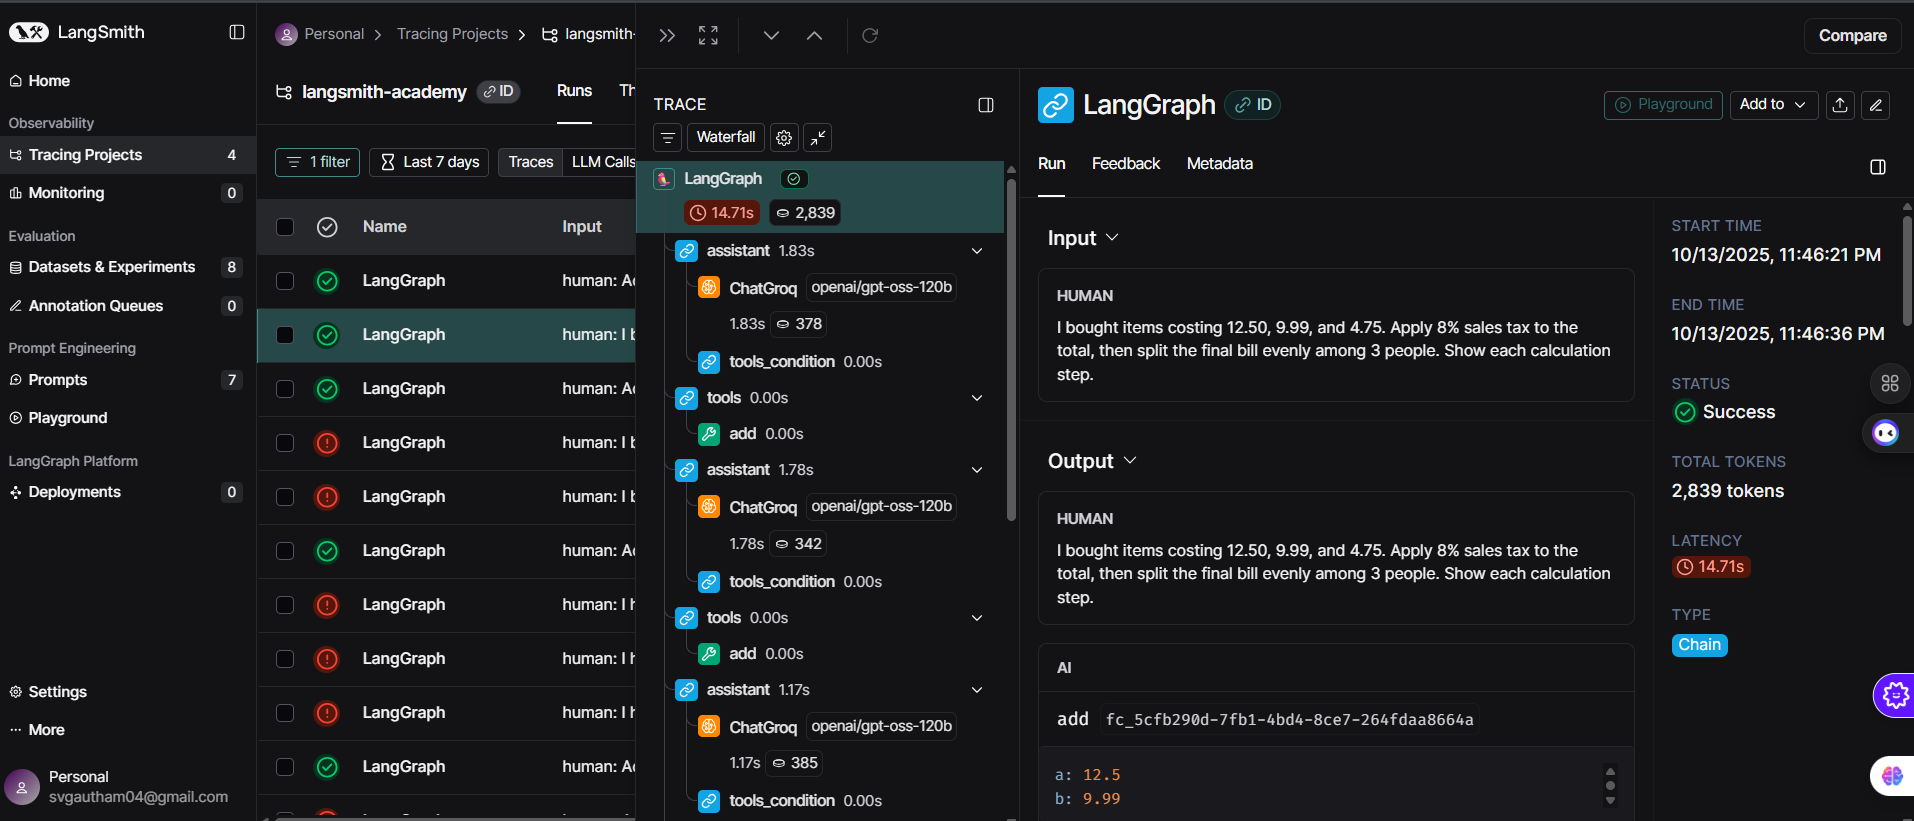

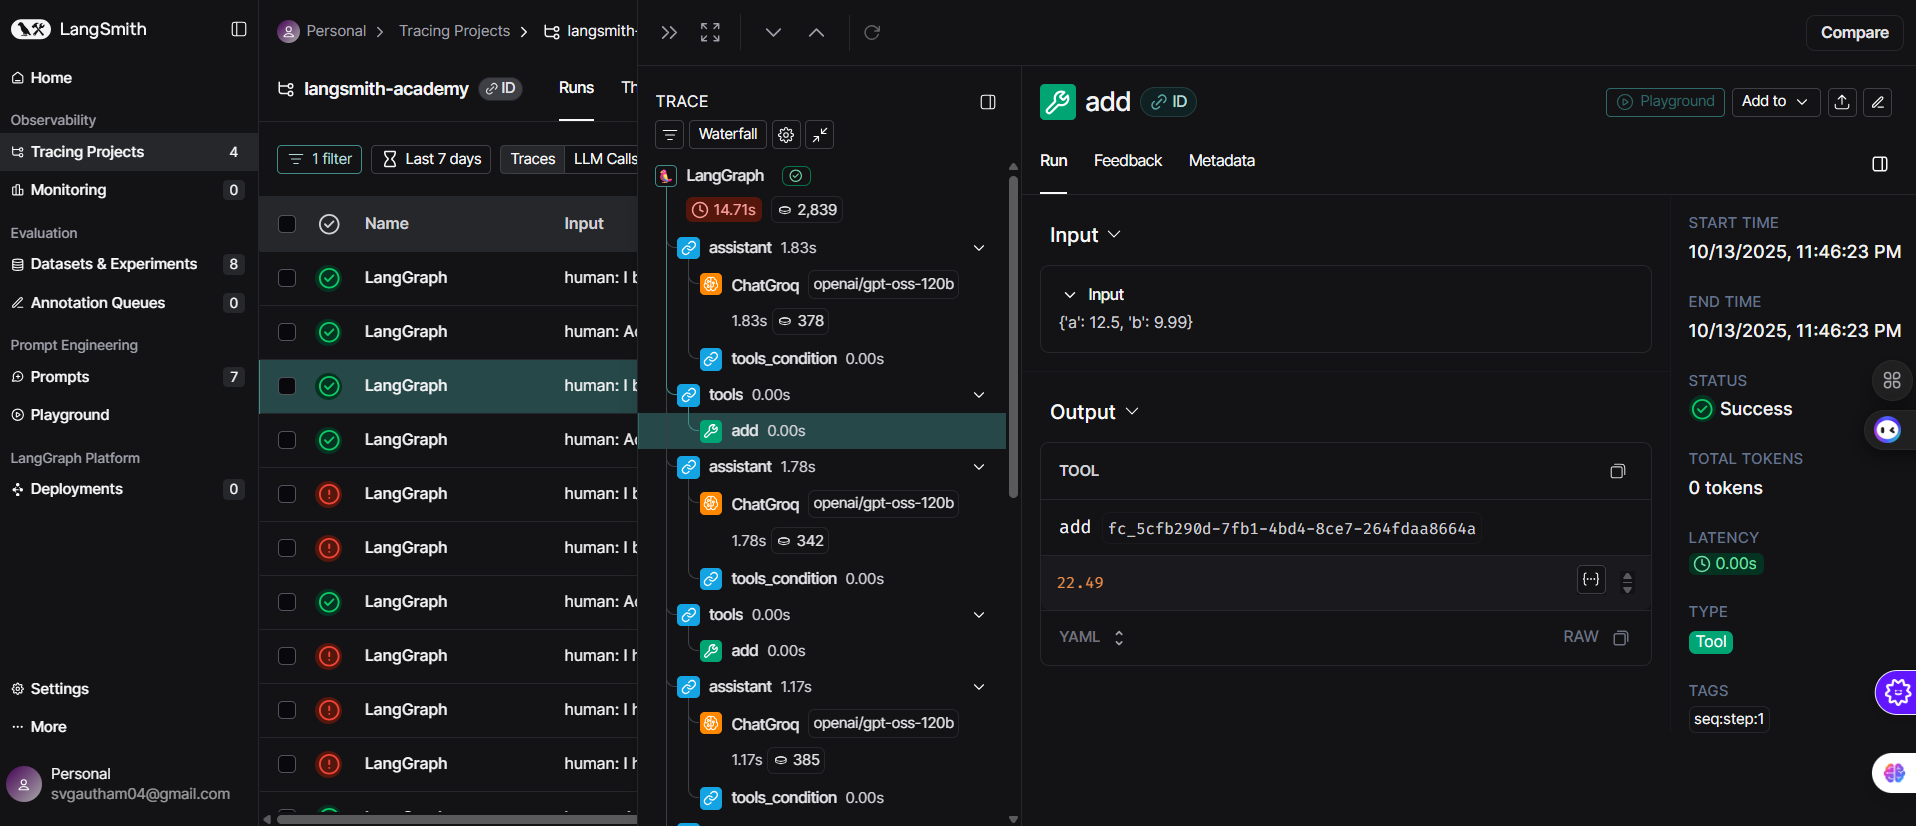

In [17]:
from IPython.display import Image
display(Image('/content/a.png'))

display(Image('/content/b.png'))

example of the lesson

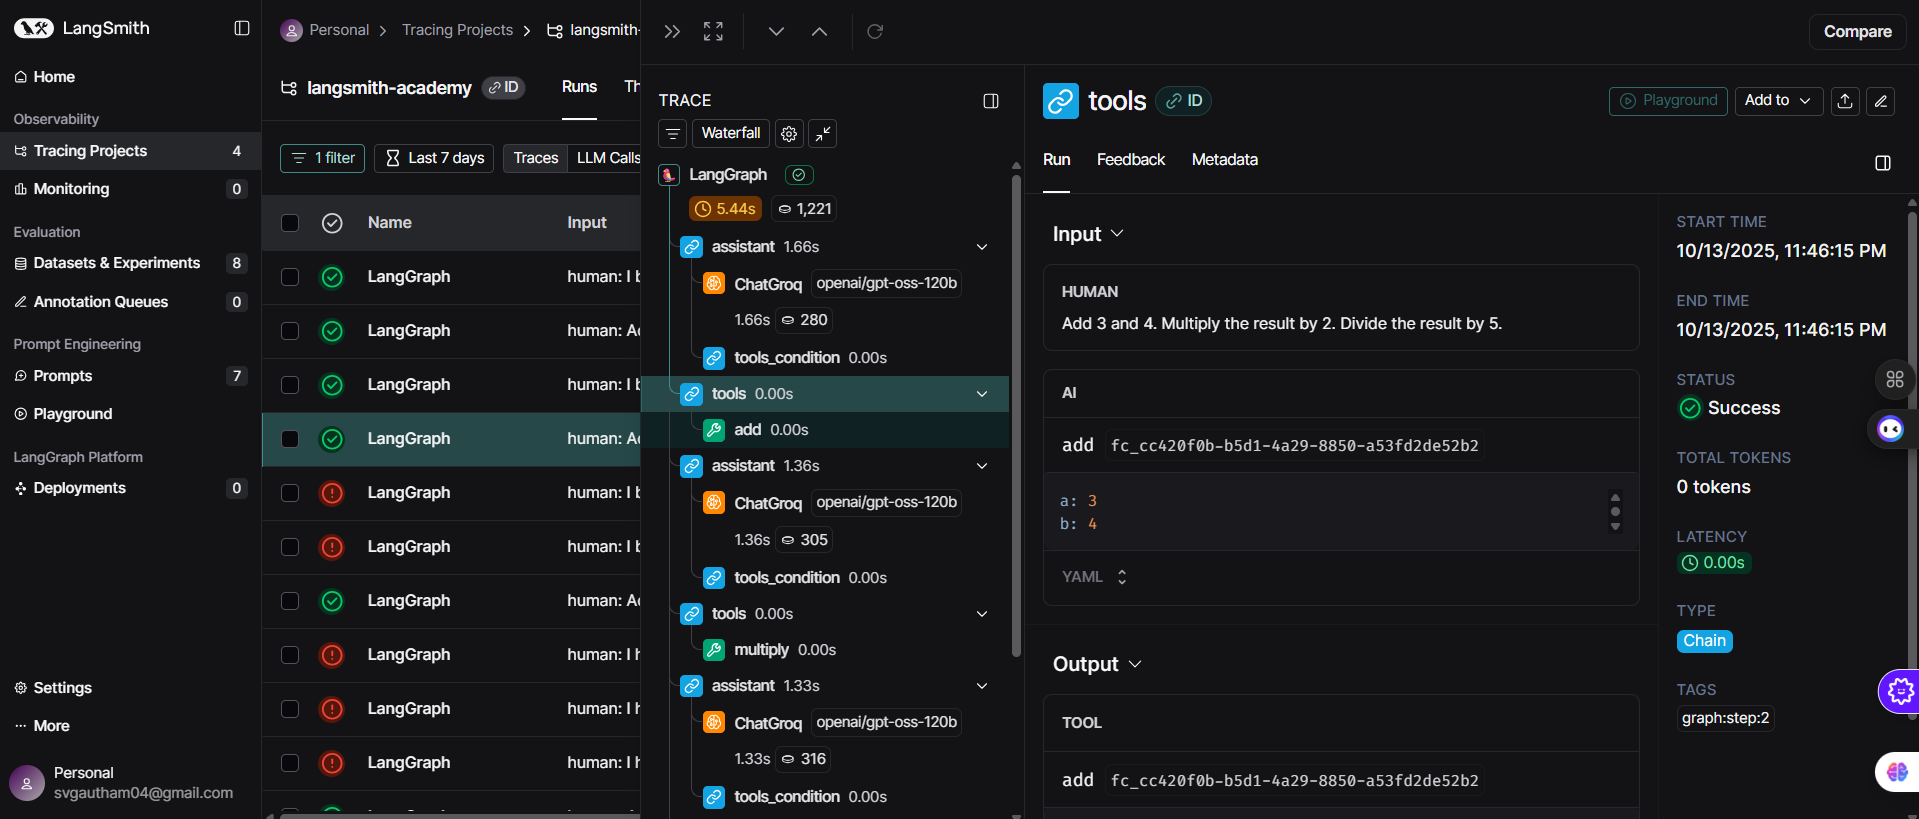

In [18]:
display(Image('/content/c.png'))